##### Tier II Object Based Image Analysis Field Boundary Detection 

In [2]:
import os
import rasterio
import affine
import matplotlib.pyplot as plt
import cv2
import numpy as np
import fiona
import sys
#import itertools as it
import matplotlib as mplt
import shapely
from shapely.geometry.polygon import Polygon as Poly
from shapely.geometry import MultiLineString, Polygon,MultiPolygon


#from osgeo import gdal

from skimage.filters import sobel
from skimage import segmentation

from skimage import feature
from skimage import data
from skimage import filters
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage.filters.rank import entropy
from skimage.morphology import disk

from skimage import (transform, exposure, segmentation,
                     filters, feature, morphology)

from skimage.color import label2rgb
from scipy import ndimage as ndi

from PIL import Image

from rasterio import plot
from rasterio.plot import show,show_hist
from rasterio.features import shapes as polygonize

from matplotlib import pyplot
from rasterio.plot import show,reshape_as_raster, reshape_as_image
from rasterio.mask import mask as msk

import visualizeGrid_v1

from visualizeGrid_v1 import read_bands,plot_bands,plot_grid,aoi_zoom

import matplotlib as mpl
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection

import warnings
warnings.filterwarnings('ignore')

#### Load Image and Calculate an NDVI Band

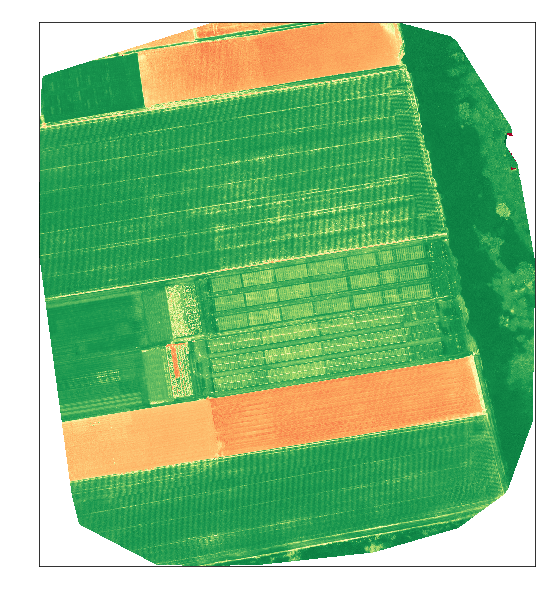

<Figure size 432x288 with 0 Axes>

In [3]:
red = 'Bands/BB2_red.tif'
nir = 'Bands/BB2_nir.tif'
out = 'Bands/BB2_NDVI.tif'
ndvi = read_bands(red,nir,out)
affine = plot_bands(out)

##### Zoom to Area of Interest

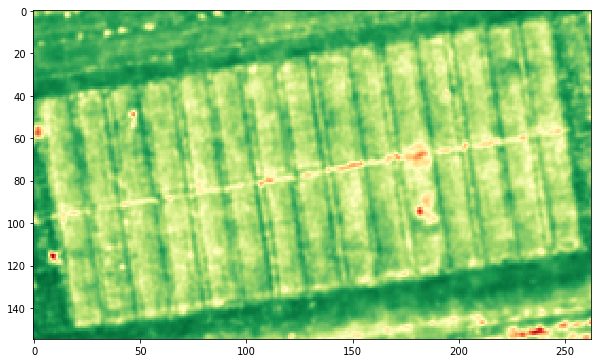

In [231]:
window=((2422,2577),(1485,1748))
with rasterio.open(out) as src:
    ndvi=src.read(1,window=window)
    ndvi[ndvi==0] = np.nan
    ndvi[ndvi < 0 ] = 0
    meta= src.meta
    crs = src.crs
    mask = src.nodata
fig,ax = plt.subplots(figsize=(10,10))
show(ndvi,cmap='RdYlGn')

#### Calculate an EVI Band

In [198]:
np.seterr(divide='ignore', invalid='ignore')

with rasterio.open(red) as src:
    RED = src.read()

with rasterio.open(nir) as src:
    NIR = src.read()

def evi(red,nir):
    evi = 2.5*((nir.astype(float) - red.astype(float))) / (nir.astype(float) + 2.4*red.astype(float) + 1)
    return evi

evi = evi(RED,NIR)

profile = meta
profile.update(driver='GTiff')
profile.update(dtype=rasterio.float32)
profile.update(nodata = 0)

with rasterio.open('Bands/BB2_evi.tif', 'w', **profile) as dst:
    dst.write(evi.astype(rasterio.float32))
    

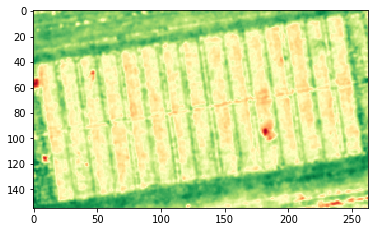

0.13823973 0.71954185


In [232]:
with rasterio.open('Bands/BB2_evi.tif') as evi:
    evi = evi.read(1,window = window )
    evi[evi == 0] = np.nan
    evi[evi < -1 ] = -1
    evi[evi > 1 ] =  1
    
show(evi,cmap='RdYlGn')    
print(evi.min(), evi.max()) 

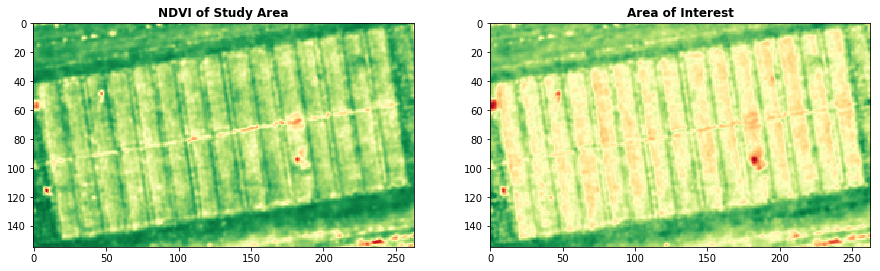

In [200]:
# Create figure and axes
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))


show((ndvi),ax=ax1,cmap='RdYlGn',title='NDVI of Study Area')


show((evi),ax=ax2,cmap='RdYlGn',title='EVI of Study Area')



##### Filter NDVI and EVI


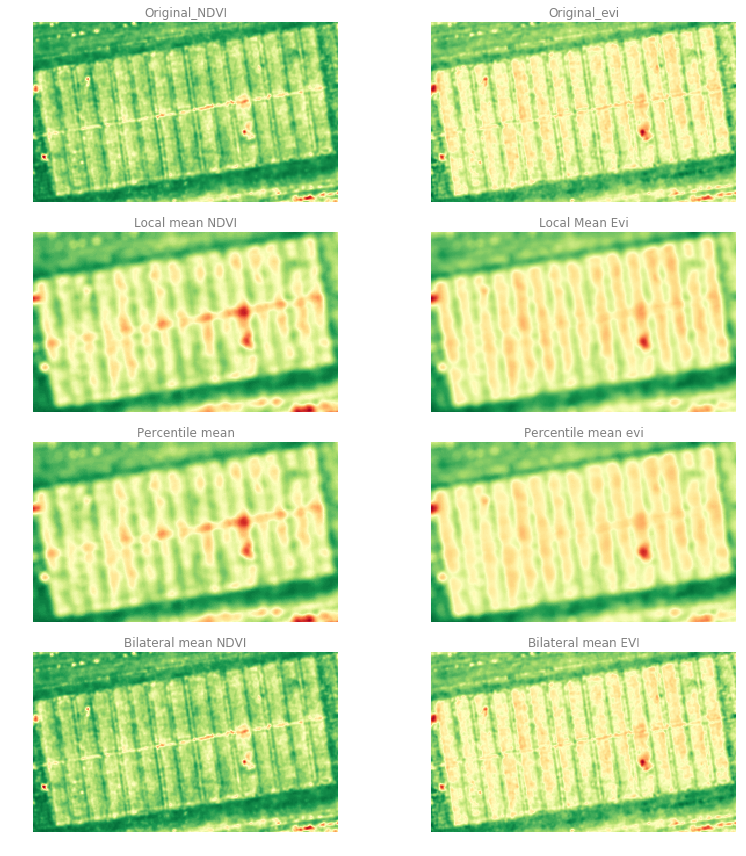

In [201]:
selem = disk(4)

percentile_result = rank.mean_percentile(ndvi, selem=selem, p0=0.01, p1=0.99)
bilateral_result = rank.mean_bilateral(ndvi, selem=selem, s0=1, s1=1)
evi_percentile_result = rank.mean_percentile(evi, selem=selem, p0=0.02, p1=0.8)
evi_bilateral_result = rank.mean_bilateral(evi, selem=selem, s0=1, s1=1)
normal_result = rank.mean(ndvi, selem=selem)
evi_normal_result = rank.mean(evi, selem=selem)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,12),
                         sharex=True, sharey=True)
ax = axes.ravel()

titles = ['Original_NDVI', 'Original_evi','Local mean NDVI','Local Mean Evi',
          'Percentile mean','Percentile mean evi', 
          'Bilateral mean NDVI','Bilateral mean EVI'
          ]
imgs = [ndvi,evi,normal_result, evi_normal_result,percentile_result,evi_percentile_result,
        bilateral_result, evi_bilateral_result]
for n in range(0, len(imgs)):
    img = ax[n].imshow(imgs[n], cmap='RdYlGn')
    ax[n].set_title(titles[n],color='grey')
    ax[n].axis('off')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    #fig.colorbar(img,ax[n])
    
plt.tight_layout()
plt.show()

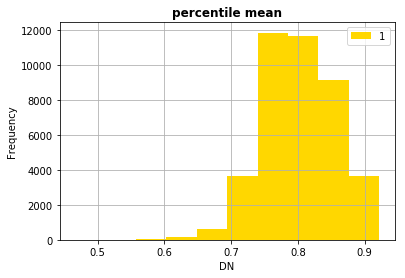

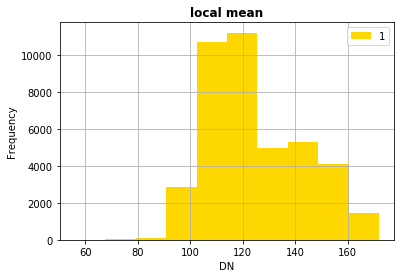

In [202]:
#fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(15,15))
show_hist(ndvi,10,title='percentile mean')
show_hist(evi_normal_result,10,title='local mean')

##### Define Sobel Edge Detection Image

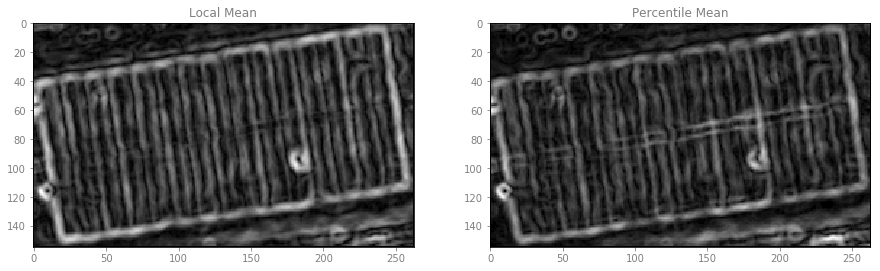

In [203]:
edges1 = sobel(evi_normal_result)
edges2 = sobel(normal_result)
local_m = edges1
percentile_m = edges2

fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(15,6))

show(local_m,ax=ax1,cmap=plt.cm.gray,interpolation='nearest')

show(percentile_m,ax=ax2,cmap=plt.cm.gray,interpolation='nearest')
ax2.set_title(label ='Percentile Mean',color='grey')
ax1.set_title(label='Local Mean',color='grey')
ax2.set_title(label ='Percentile Mean',color='grey')
ax1.set_title(label='Local Mean',color='grey')
ax1.tick_params(axis='both', colors='grey')
ax2.tick_params(axis='both', colors='grey')

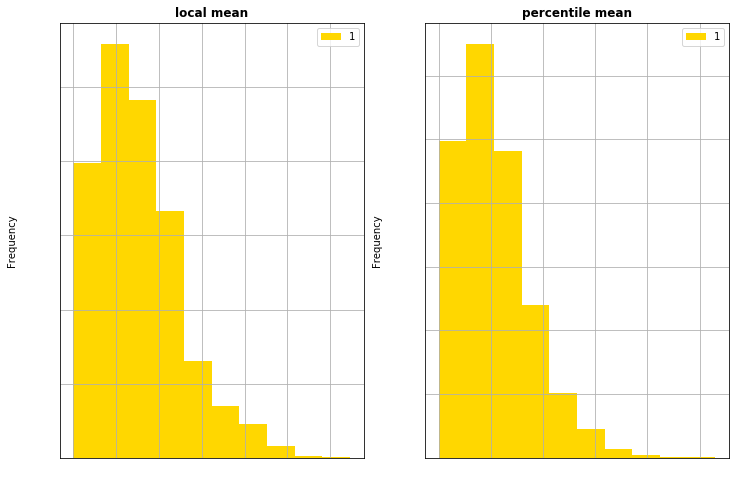

In [204]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(12,8))
show_hist(local_m,ax=ax1,bins=10,title='local mean')
show_hist(percentile_m,ax=ax2,bins=10,title='percentile mean')
ax1.xaxis.label.set_color('white')
ax2.xaxis.label.set_color('white')
ax1.tick_params(axis='both', colors='white')
ax2.tick_params(axis='both', colors='white')

#### Apply Threshold to Sobel Edge Images

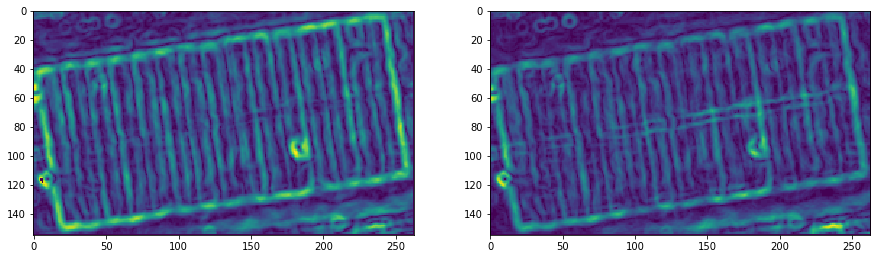

In [226]:
bounds1 =sobel(evi_normal_result)
bounds2 = sobel(normal_result)
#bounds2 = bounds2.astype(rasterio.float64)
bounds1[bounds1 >  0.06] = 0
bounds2[bounds2 >  0.06] = 0



fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
show(bounds1,ax=ax1) #,cmap='RdYlGn')
show(bounds2,ax=ax2) #,cmap='RdYlGn')

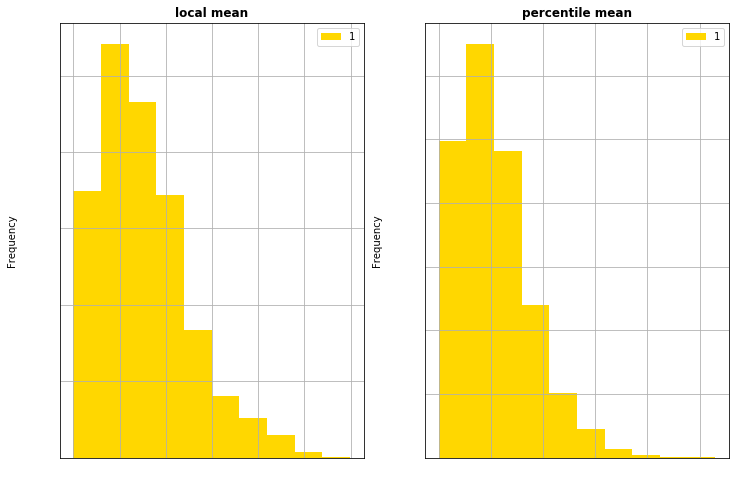

In [207]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(12,8))
show_hist(bounds1,ax=ax1,bins=10,title='local mean')
show_hist(bounds2,ax=ax2,bins=10,title='percentile mean')
ax1.xaxis.label.set_color('white')
ax2.xaxis.label.set_color('white')
ax1.tick_params(axis='both', colors='white')
ax2.tick_params(axis='both', colors='white')

##### EVI Image Selected 
###### In this case EVI is selected to Segment as it more clearly defines boundaries

###### Define a marker image (boundary/no-boundary) image to use in the segmentation 

(-0.5, 262.5, 154.5, -0.5)

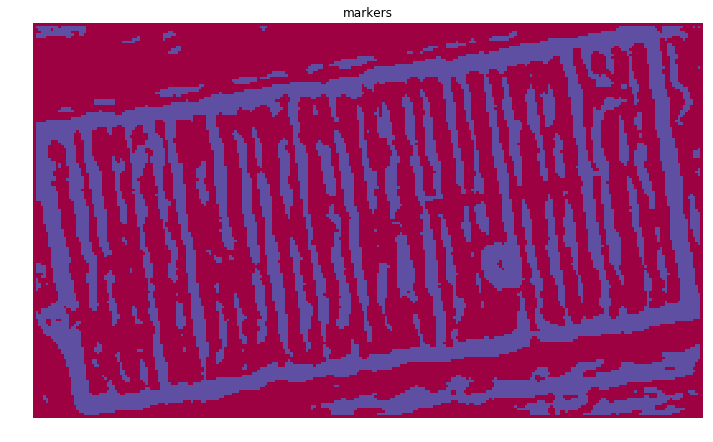

In [228]:
markers = np.zeros_like(bounds1)
#markers[bounds1 == 0 ] = 0
markers[bounds1 < 0.017 ] = 1
markers[bounds1 > 0.017 ] = 2

#markers[percentile_result < 100] = 3
#markers[percentile_result < 50] = 3

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(markers, cmap=plt.cm.Spectral, interpolation='nearest')
ax.set_title('markers')
ax.axis('off')
#ax.set_adjustable('box-forced

##### Segment the Sobel Edge image with Marker image

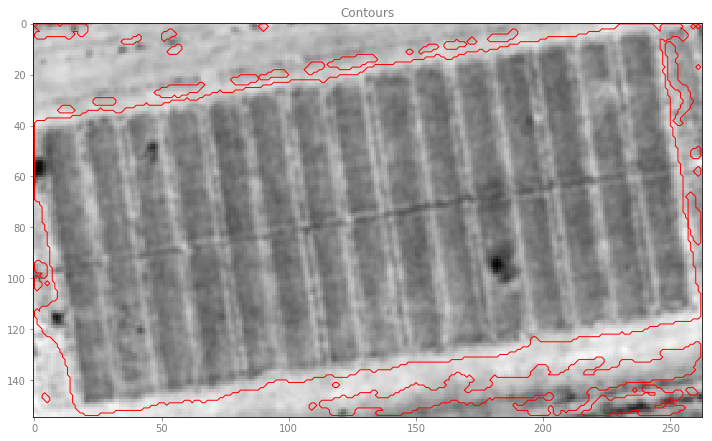

In [233]:
from skimage import morphology
from skimage.color import label2rgb
from scipy import ndimage as ndi

segmentation = morphology.watershed(bounds1,markers,connectivity=3)#,watershed_line=True)

#fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
#ax.set_title('segmentation')
#ax.axis('off')
#ax.set_adjustable('box-forced')

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_plots, _ = ndi.label(segmentation)
plot_overlay = label2rgb(labeled_plots, image=evi)

type(labeled_plots)

titles = 'Contours'
fig, axes = plt.subplots( figsize=(10, 10))
axes.imshow(evi, cmap=plt.cm.gray, interpolation='nearest')
img= axes.contour(segmentation,levels=[0] ,linewidths=1,colors='r')#,extent= (10,1900,200,1000))
axes.set_title(titles,color='grey')
axes.axis('on')
axes.xaxis.label.set_color('grey')
axes.tick_params(axis='both', colors='grey')
    
plt.tight_layout()
type(plot_overlay)
pf = segmentation.astype('int32')

##### Define detected plots

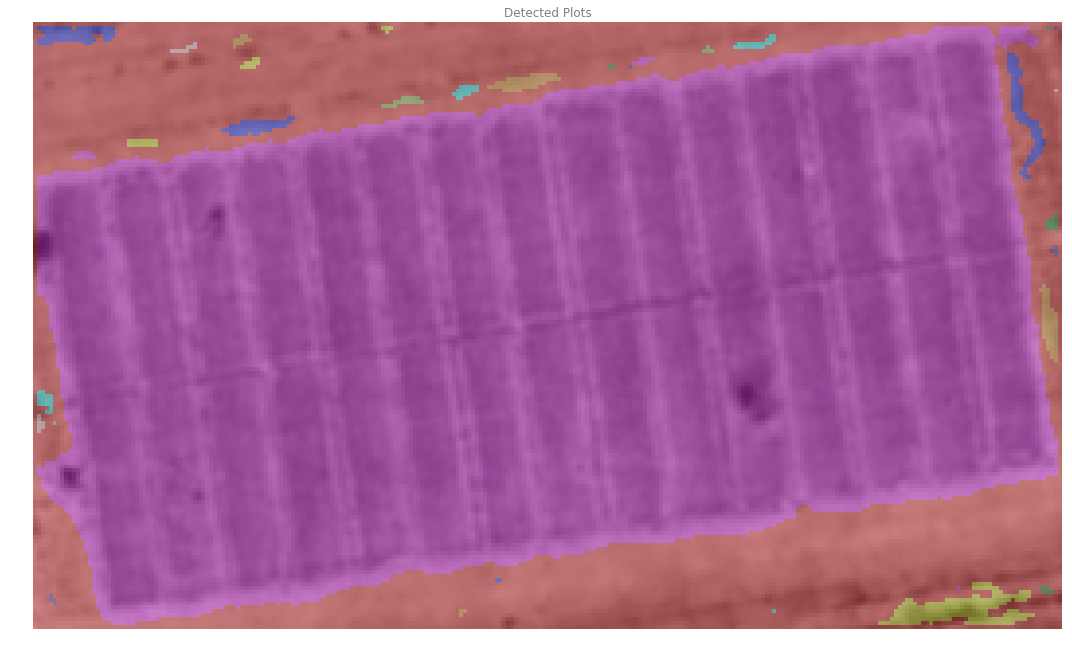

In [234]:
titles = 'Detected Plots'
fig, axes = plt.subplots(figsize=(15, 15))
axes.imshow(plot_overlay, interpolation='nearest')
axes.set_title(titles)
axes.axis('off')
axes.set_title(label=titles,color='grey')
axes.tick_params(axis='both', colors='grey')

plt.tight_layout()

##### Write Detected Plot contours to a vector file

In [235]:
def write_segments(fn, segments,mask, source_crs,
                   raster_meta, write_raster=True):
    
    segments = segments.astype('int32')
    if write_raster:
        raster_meta.update(dtype=rasterio.int32,
                           count=1,
                           compress='lzw',
                           nodata=0)
        raster_fn = os.path.splitext(fn)[0] + '.tif'
        with rasterio.open(raster_fn, 'w', **raster_meta) as gtiff:
            gtiff.write(segments)
            gtiff.write_mask(mask)

    shp_schema = {'geometry': 'Polygon', 'properties': {'id': 'int'}}
    with fiona.open(fn, 'w', driver='ESRI Shapefile',
                    crs=source_crs, schema=shp_schema) as shpfile:
        for shape, val, in polygonize(segments,
                                      transform=raster_meta['transform'],
                                      mask=mask):
            record = dict(geometry=shape, id=val, properties={'id': val})
                     
            shpfile.write(record)
                          
    return record